In [1]:
import sys
sys.path.append('..')
import umbrella_mesh
import elastic_rods
import linkage_vis
from umbrella_mesh import UmbrellaEnergyType
from bending_validation import suppress_stdout as so

In [2]:
import numpy as np

In [3]:
input_path = '../../data/saddle.json'
from load_jsondata import read_data
input_data, io = read_data(filepath = input_path)
import mesh
target_mesh = mesh.Mesh(input_data['target_v'], input_data['target_f'])

### Initialization

In [4]:
curr_um = umbrella_mesh.UmbrellaMesh(io)
thickness = io.material_params[6]
curr_um.targetDeploymentHeight = thickness


In [5]:
# curr_um.setMaterial(elastic_rods.RodMaterial('rectangle', 1400, 0.35, cross_section, stiffAxis=elastic_rods.StiffAxis.D1), 
#                     elastic_rods.RodMaterial('rectangle', 14000, 0.35, cross_section, stiffAxis=elastic_rods.StiffAxis.D1))

In [6]:
curr_um.energy(UmbrellaEnergyType.Full)

8.1071893602145e-28

### Pin Rigid Motion



In [7]:
driver = curr_um.centralJoint()
jdo = curr_um.dofOffsetForJoint(driver)
# fixedVars = list(range(jdo, jdo + 6)) + curr_um.rigidJointAngleDoFIndices()
fixedVars = curr_um.rigidJointAngleDoFIndices()

### Equilibrium solve

In [8]:
import py_newton_optimizer
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-10
OPTS.verbose = 1
OPTS.beta = 1e-8
OPTS.niter = 1000
OPTS.verboseNonPosDef = False

In [9]:
rod_colors = []
for seg_id in range(curr_um.numSegments()):
    rod_colors.append(np.ones(curr_um.segment(seg_id).rod.numVertices())*seg_id)

In [10]:

import mesh
from visualization_helper import *
view = linkage_vis.LinkageViewerWithSurface(curr_um, target_mesh, width=1024, height=600)
set_surface_view_options(view, color = 'green', surface_color = 'gray', umbrella_transparent = False, surface_transparent = True)
# view = linkage_vis.LinkageViewer(curr_um, width=1024, height=600)
view.averagedMaterialFrames = True
view.showScalarField(rod_colors)

view.show()

Renderer(camera=PerspectiveCamera(aspect=1.7066666666666668, children=(PointLight(color='#999999', position=(0…

In [11]:
# view.update(vectorField = [[frame.d2 for frame in s.rod.deformedConfiguration().materialFrame] for s in curr_um.segments()])

In [12]:
# from load_jsondata import write_deformed_config
# write_deformed_config(input_data, curr_um, input_path[:-5]+'_undeformed.json', write_stress = False)

In [13]:
dof = curr_um.getDoFs()
for i in range(curr_um.numJoints()):
    if (curr_um.joint(i).jointType() == umbrella_mesh.JointType.X):
        dof[curr_um.dofOffsetForJoint(i) + 6] = 1e-6
curr_um.setDoFs(dof)

In [14]:
view.showScalarField(rod_colors)

In [15]:
def eqm_callback(prob, i):
    if (i % 20 == 0):
        view.showScalarField(rod_colors)

In [26]:
curr_um.uniformDeploymentEnergyWeight = 1
# curr_um.deploymentForceType = umbrella_mesh.DeploymentForceType.Constant
deployment_ratio = 1
curr_um.targetDeploymentHeight = deployment_ratio*thickness
curr_um.repulsionEnergyWeight = 0
curr_um.attractionWeight = 1e-4
curr_um.setHoldClosestPointsFixed(False)
curr_um.scaleInputPosWeights(0.5)

In [27]:
curr_um.energyElastic(), curr_um.energyDeployment(), curr_um.energyRepulsion(), curr_um.energyAttraction()
# view.update()
# view.showScalarField(rod_colors)

(6.226849372268259e-05, 0.0001270022870113054, 0.0, 1.0961854351131122e-07)

In [28]:
# driver = curr_um.centralJoint()
# jdo = curr_um.dofOffsetForJoint(driver)
# fixedVars = list(range(jdo, jdo + 6)) + curr_um.rigidJointAngleDoFIndices()
# fixedVars = curr_um.rigidJointAngleDoFIndices()

In [29]:

report = umbrella_mesh.compute_equilibrium(curr_um, callback = eqm_callback, options = OPTS, fixedVars = fixedVars)
view.showScalarField(rod_colors)

0	0.00018938	0.0223137	0.0223137	0.001	1
Added constraint 665 to working set
Added constraint 666 to working set
Added constraint 670 to working set
Added constraint 673 to working set
Added constraint 674 to working set
Added constraint 677 to working set
Added constraint 680 to working set
Added constraint 682 to working set
Added constraint 685 to working set
Added constraint 687 to working set
Added constraint 689 to working set
Added constraint 690 to working set
Added constraint 694 to working set
Added constraint 697 to working set
Added constraint 699 to working set
Added constraint 702 to working set
Added constraint 704 to working set
Added constraint 707 to working set
Added constraint 708 to working set
Added constraint 709 to working set
Added constraint 711 to working set
Added constraint 714 to working set
Added constraint 716 to working set
Added constraint 719 to working set
Added constraint 721 to working set
Added constraint 724 to working set
Added constraint 725 to

In [30]:
report.success

True

In [37]:
import importlib
import visualization_helper
import plate_rigidity_helper
importlib.reload(plate_rigidity_helper)
importlib.reload(visualization_helper)

alpha,  beta, e = plate_rigidity_helper.plate_top_bot_angle(curr_um, input_data['uid_top_bot_map'])
view.showScalarField(plate_rigidity_helper.fill_plate_vars_with_center(curr_um, beta))

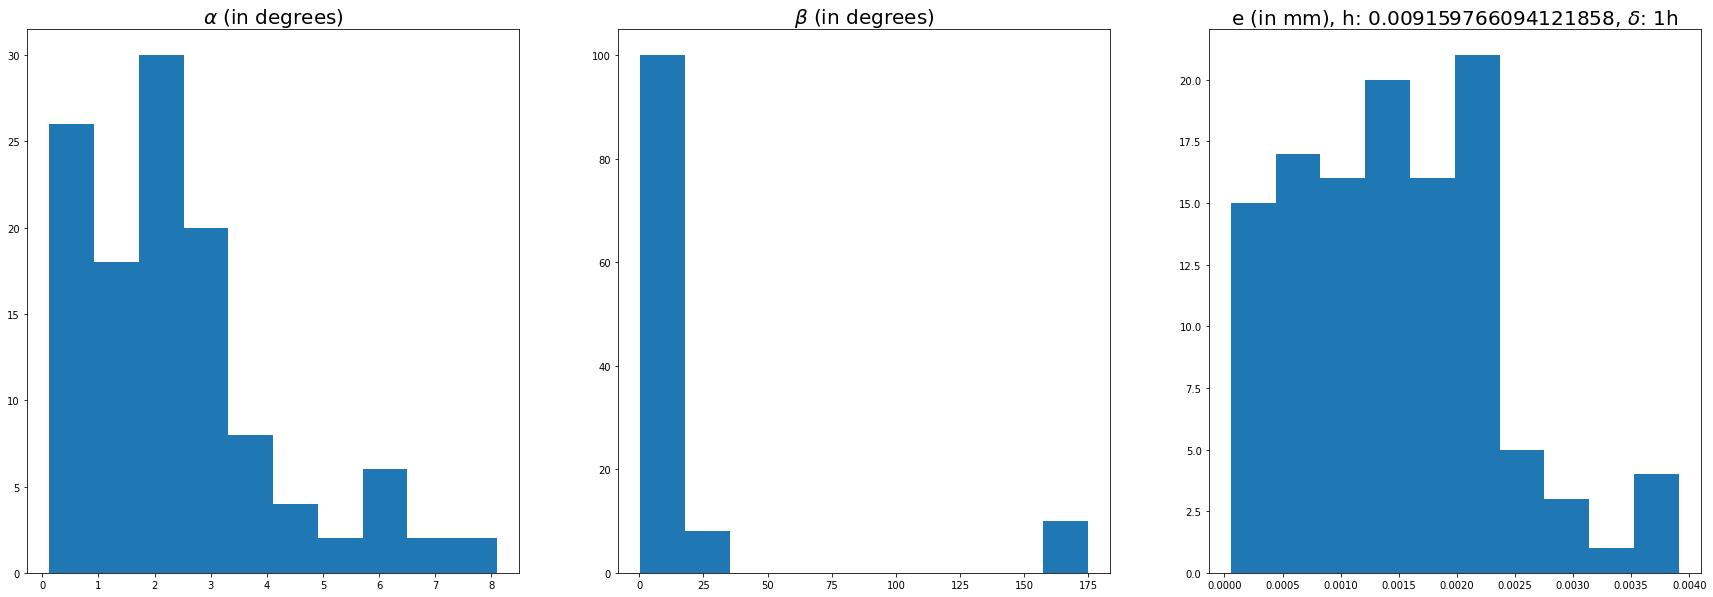

In [38]:
plate_rigidity_helper.plot_alpha_beta_e(curr_um, alpha, beta, e, thickness, deployment_ratio)

In [128]:
normal_angle, avg_angle, max_angle = plate_rigidity_helper.compute_plate_normal_variation(curr_um)
normal_angle_vis, avg_angle_vis, max_angle_vis = plate_rigidity_helper.fill_plate_vars_with_center(curr_um, normal_angle), plate_rigidity_helper.fill_plate_vars_with_center(curr_um, avg_angle), plate_rigidity_helper.fill_plate_vars_with_center(curr_um, max_angle)
view.showScalarField(max_angle_vis)

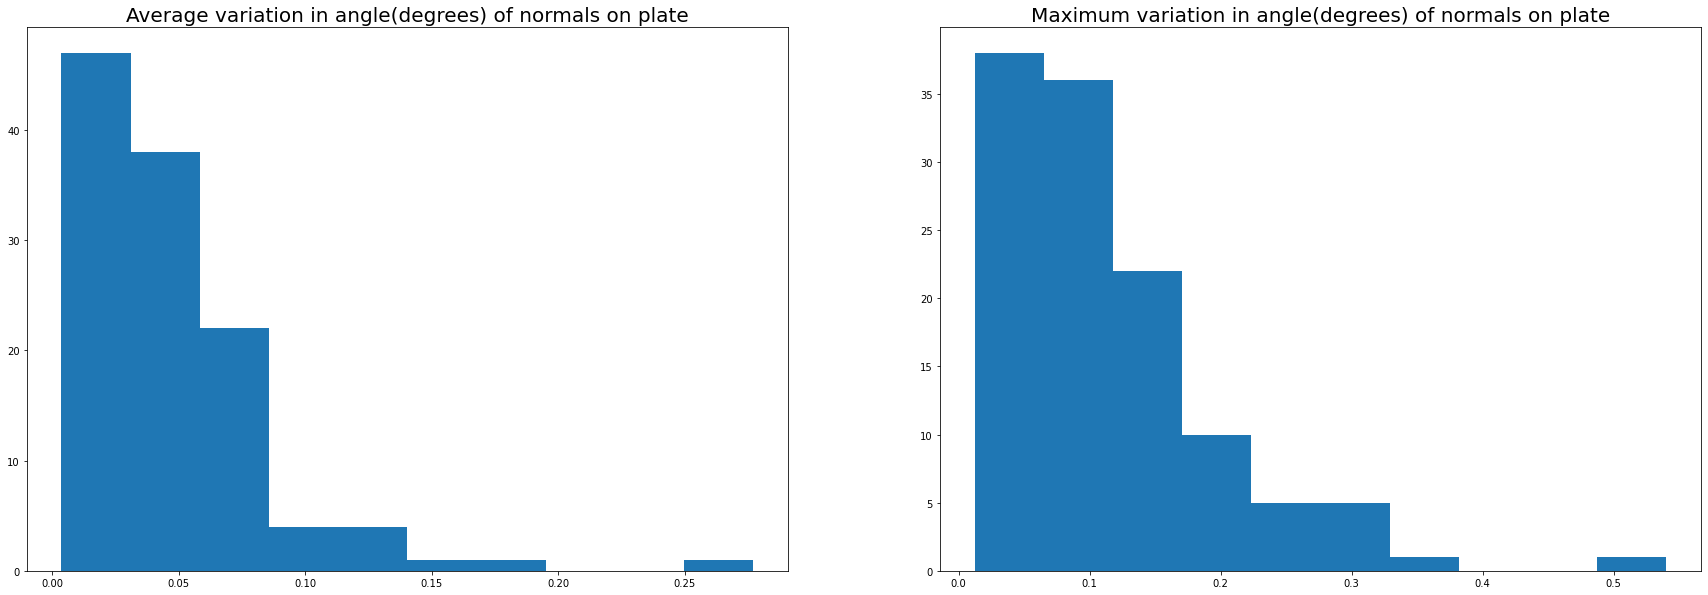

In [129]:
plate_rigidity_helper.plot_rigidity_angles(curr_um)

In [46]:
# from load_jsondata import write_deformed_config
# write_deformed_config(input_data, curr_um, input_path[:-5]+'_deformed.json', write_stress = True)

0.009159766094121858


(array([ 5.,  7., 13.,  4.,  1.,  7.,  4.,  7.,  9.,  2.]),
 array([0.00913583, 0.00914209, 0.00914836, 0.00915462, 0.00916088,
        0.00916714, 0.0091734 , 0.00917966, 0.00918592, 0.00919219,
        0.00919845]),
 <BarContainer object of 10 artists>)

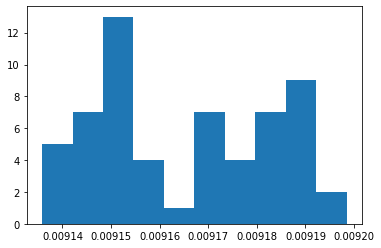

In [36]:
print(thickness)
import matplotlib.pyplot as plt
plt.hist(curr_um.umbrellaHeights)


In [ ]:
curr_um.uniformDeploymentEnergyWeight = 0
umbrella_mesh.compute_equilibrium(curr_um, callback = eqm_callback, options = OPTS, fixedVars = fixedVars)
view.update(scalarField=rod_colors)

In [ ]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10,8))
for i in range(len(angles[0])):
    plt.plot([a[i] / np.pi for a in angles])
plt.title('Joint Angles')
plt.xlabel('Newton Iteration')
plt.ylabel('Pi Radians')
plt.tight_layout()
plt.show()

In [ ]:
np.linalg.norm(curr_um.gradient())

In [ ]:
len([j.jointType() for j in curr_um.joints()])

In [ ]:
len(curr_um.jointAngleDoFIndices())

In [ ]:
curr_um.getDoFs()[curr_um.jointAngleDoFIndices()]

In [ ]:
import umbrella_finite_diff
umbrella_finite_diff.gradient_convergence_plot(curr_um, umbrellaEnergyType=umbrella_mesh.UmbrellaEnergyType.Deployment, etype=elastic_rods.EnergyType.Full)

In [ ]:
curr_um.updateSourceFrame()

In [ ]:
umbrella_finite_diff.hessian_convergence_plot(curr_um, umbrellaEnergyType=umbrella_mesh.UmbrellaEnergyType.Deployment, etype=elastic_rods.EnergyType.Full)

In [28]:
bending_stress = curr_um.maxBendingStresses()

In [29]:
view.showScalarField(bending_stress)